In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import torch
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
import ot
from tqdm import tqdm
import sys
sys.path.append("../")
from lib.linear_gromov import *
from lib.gromov_barycenter import *
from lib.opt import opt_lp,emd_lp
from lib.gromov import *
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS
import ot

from sklearn import manifold

import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import plotly
import plotly.express as px
import sklearn
import pandas as pd
import random

from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra


/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
4000it [00:00, 42571.83it/s]
4000it [00:00, 16830.75it/s]
800it [00:00, 35063.20it/s]
800it [00:00, 17500.79it/s]
800it [00:00, 10387.40it/s]
800it [00:00, 10344.01it/s]
800it [00:00, 10132.61it/s]
/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


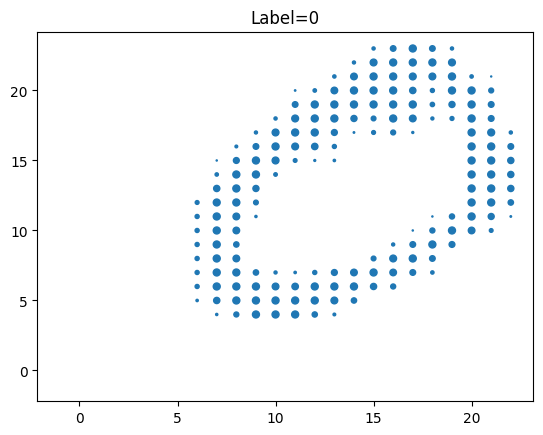

In [2]:
def sample_images_by_label(X, Y, target_label, sample_size=10,rd_seed=0):
    """
    Displays a specified number of random sample images from the MNIST dataset with the given label.

    loss_parameters:
    X (numpy.ndarray): The MNIST dataset of images.
    Y (numpy.ndarray): The labels corresponding to the images.
    target_label (int): The label of the images to sample.
    sample_size (int): The number of images to display. Default is 10.

    Returns:
    None
    """
    # Find indices of images with the specified label
    indices = np.where(Y == target_label)[0]
    np.random.rand(rd_seed)
    if len(indices) == 0:
        print(f"No images found with label {target_label}.")
        return

    # Adjust sample size if there are fewer images available
    if sample_size > len(indices):
        print(f"Only {len(indices)} images available with label {target_label}. Displaying all.")
        sample_size = len(indices)

    # Randomly select indices from the found indices
    sample_indices = np.random.choice(indices, size=sample_size, replace=False)

    return X[sample_indices], Y[sample_indices]

def split_pmf(X):
    b=X[:,2]
    X1=X[b!=-1,0:2]
    pmf=b[b!=-1]
    pmf=pmf/pmf.sum()
    return X1,pmf

def center(X):
    return X- X.mean(0)

def rotate(X,seed=0):
    X= X- X.mean(0)
    np.random.seed(seed)
    theta=np.random.rand(1)[0]*2*np.pi
    c,s=np.cos(theta),np.sin(theta)
    rot_d=np.array([[c,-s],[s,c]])
    flip = np.random.randint(0,2)
    X_rot=X.dot(rot_d)
    if flip ==1:
        flip_d=np.array([[0,1],[1,0]])
        X_rot=X_rot.dot(flip)
    return X_rot

def add_noise(X,pmf,eta=0,mass=1,seed=0,low_bound=-20,upper_bound=25):
    if eta==0:
        return X,pmf
    
    np.random.seed(seed)
    n_pts = X.shape[0]
    n_noise = int(n_pts * eta)
    mass=pmf.sum()
    mass_noise=eta*mass    
    noise_pts = np.random.randint(low_bound, upper_bound, size=(n_noise, 2))
    pmf_noise=np.ones(n_noise)/n_noise*mass_noise 

    X1=np.concatenate((X,noise_pts))
    pmf1=np.concatenate((pmf,pmf_noise))
    return X1,pmf1

df = pd.read_csv("data/train.csv")
train_X = df[df.columns[1:]].to_numpy()
train_y = df[df.columns[0]].to_numpy()
train_X = train_X.reshape(train_X.shape[0], -1, 3)


ind = 1
plt.scatter(train_X[ind,:,0],train_X[ind,:,1],s=train_X[ind,:,2]*.1)
plt.title('Label=%d'%train_y[ind])

df = pd.read_csv("data/test.csv")
test_X = df[df.columns[1:]].to_numpy()
test_y = df[df.columns[0]].to_numpy()
test_X = test_X.reshape(test_X.shape[0], -1, 3)

                
    





# sample the training data 
def sample_dataset(train_X,train_y,labels,sample_size=500,seed=0):
    np.random.rand(seed)
    train_X_sample=[]
    train_Y_sample=[]
    train_X_sample_pos=[]
    train_X_sample_pmf=[]
    for label in labels:
        X_sample,Y_sample=sample_images_by_label(train_X,train_y,label,sample_size=sample_size)
        train_X_sample.append(X_sample)
        train_Y_sample.append(Y_sample)
    train_X_sample,train_Y_sample=np.concatenate(train_X_sample),np.concatenate(train_Y_sample)

    for i,X in tqdm(enumerate(train_X_sample)):
        pos,pmf=split_pmf(X)
        pos= pos- pos.mean(0)
        train_X_sample_pos.append(pos)
        train_X_sample_pmf.append(pmf)
    return train_X_sample_pos,train_X_sample_pmf,train_Y_sample

def process_dataset(test_X_sample_pos,test_X_sample_pmf,eta=0,seed=0):
    test_X_sample_pos1,test_X_sample_pmf1=[],[]
    for i,(pos,pmf) in tqdm(enumerate(zip(test_X_sample_pos,test_X_sample_pmf))):
        pos2=rotate(pos,seed=i+seed)
        pos3,pmf3=add_noise(pos2,pmf,eta=eta,mass=1,seed=0,low_bound=-25,upper_bound=25)
        test_X_sample_pos1.append(pos3)
        test_X_sample_pmf1.append(pmf3)
    return test_X_sample_pos1,test_X_sample_pmf1

# construct training set: 
size1=500

labels=[0,1,2,3,4,6,7,8]
train_X_sample_pos,train_X_sample_pmf,train_Y_sample=sample_dataset(train_X,train_y,labels=labels,sample_size=size1)
train_X_sample_pos1,train_X_sample_pmf1=process_dataset(train_X_sample_pos,train_X_sample_pmf,eta=0,seed=2)

train_sample={}
train_X_sample_pos=train_X_sample_pos+train_X_sample_pos1
train_X_sample_pmf=train_X_sample_pmf+train_X_sample_pmf1
train_Y_sample=np.concatenate((train_Y_sample,train_Y_sample))
train_sample['train_X_sample_pos']=train_X_sample_pos
train_sample['train_X_sample_pmf']=train_X_sample_pmf 
train_sample['train_Y_sample']=train_Y_sample
torch.save(train_sample,'data/train_sample_%i.pt'%size1)


size2=100
test_X_sample_pos,test_X_sample_pmf,test_Y_sample=sample_dataset(test_X,test_y,labels=labels,sample_size=size2)

test_sample={}
test_sample['test_X_sample_pos']=test_X_sample_pos
test_sample['test_X_sample_pmf']=test_X_sample_pmf
test_sample['test_Y_sample']=test_Y_sample
torch.save(test_sample,'data/test_sample_%i.pt'%size2)

eta_list=[0,0.1,0.3,0.5]
for eta in eta_list:
    test_X_sample_pos1,test_X_sample_pmf1=process_dataset(test_X_sample_pos,test_X_sample_pmf,eta)
    test_sample={}
    test_sample['test_X_sample_pos']=test_X_sample_pos1
    test_sample['test_X_sample_pmf']=test_X_sample_pmf1
    test_sample['test_Y_sample']=test_Y_sample
    torch.save(test_sample,'data/test_sample_%i_%0.3f.pt'%(size2,eta))





In [3]:
import time
# construct mm_space

def pos_to_mm_space(pos,loss='sqrt',loss_param=None):
    if loss == 'sqrt':
        M=np.sqrt(cost_matrix_d(pos,pos))
    if loss== 'square':
        M=cost_matrix_d(pos,pos)
    elif loss=='graph':
        n=loss_param['n_neighbors']
        knnG1 = kneighbors_graph(pos, n_neighbors=n,mode='distance')
        M = dijkstra(knnG1,directed=False)
    n=M.shape[0]
    pmf=np.ones(n)/n
    return M,pmf
    

loss='sqrt'
loss_param=None

Ms=[]
sizes=[]
for (pos,pmf) in tqdm(zip(train_X_sample_pos,train_X_sample_pmf)):
    M,height=pos_to_mm_space(pos,loss)
    Ms.append(M)
    sizes.append(pmf.shape[0])
sizes=np.array(sizes)
# compute pmf 
n_labels=8
idxs =[i*size1 for i in range(n_labels)]
N=int(np.mean(sizes))+50
Cs=[Ms[idx] for idx in idxs]
ps=[train_X_sample_pmf[idx] for idx in idxs]
pmf_ref=np.ones(N)/N
st=time.time()
M_ref=ot.gromov.gromov_barycenters(N, Cs = Cs,
                                            ps = ps, p = pmf_ref, lambdas = ot.unif(len(idxs)), 
                                            max_iter=100, tol=1e-5,random_state=0,log=False)
et=time.time()
print('wall_clock time is',et-st)
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=100,normalized_stress='auto')
pos_ref=mds.fit_transform(M_ref)

ref={}
ref['pos_ref']=pos_ref
ref['M_ref']=M_ref
ref['pmf_ref']=pmf_ref
torch.save(ref,'data/ref.pt')
print('error is',np.sqrt(ot.dist(pos_ref,pos_ref))-M_ref)


8000it [00:04, 1864.90it/s]


wall_clock time is 47.696218967437744
error is [[-0.11294858  0.0870833   0.02405208 ... -0.19196691 -0.2395217
   0.00522157]
 [ 0.0870833  -0.34852225  0.18117135 ...  0.09923475 -0.01352895
  -0.00110209]
 [ 0.02405208  0.18117135 -0.29121247 ...  0.07809446 -0.11832527
   0.02196869]
 ...
 [-0.19196691  0.09923475  0.07809446 ... -0.16466243 -0.24064639
  -0.05477863]
 [-0.2395217  -0.01352895 -0.11832527 ... -0.24064639 -0.11141609
  -0.12227052]
 [ 0.00522157 -0.00110209  0.02196869 ... -0.05477863 -0.12227052
  -0.28493623]]


In [180]:
# visulization: 
ref=torch.load('data/ref.pt')
pos_ref=ref['pos_ref']
M_ref=ref['M_ref']
pmf_ref=ref['pmf_ref']
print(pmf_ref.shape)
eta_list=[0,0.05,0.10,0.3,0.5]

(167,)


In [186]:

# size1=500
# size2=100
    
# train_sample=torch.load('data/train_sample_%i.pt'%(size1))
    
# train_X_sample_pos=train_sample['train_X_sample_pos']
# train_X_sample_pmf=train_sample['train_X_sample_pmf']
# train_Y_sample=train_sample['train_Y_sample']

# embeddings=lot_embeddings(pos_ref,pmf_ref,train_X_sample_pos,train_X_sample_pmf)
# lot_embedding_train=np.array(embeddings)
# torch.save(lot_embedding_train,'results/lot_embedding_train.pt')

test_sample=torch.load('data/test_sample_%i.pt'%(size2))
    
test_X_sample_pos=test_sample['test_X_sample_pos']
test_X_sample_pmf=test_sample['test_X_sample_pmf']
test_Y_sample=test_sample['test_Y_sample']


embeddings=lot_embeddings(pos_ref,pmf_ref,test_X_sample_pos,test_X_sample_pmf)
lot_embedding_test=np.array(embeddings)
torch.save(lot_embedding_test,'results/lot_embedding_test.pt')

### Learn a simple linear classifier on the embedded points
st=time.time()
cls = LogisticRegression(max_iter=5000)
cls.fit(lot_embedding_train.reshape((lot_embedding_train.shape[0],-1)),train_Y_sample)
score=cls.score(lot_embedding_test.reshape((lot_embedding_test.shape[0],-1)),test_Y_sample)
et=time.time()
print('wall_time in trainint+testing is',et-st)
print('lot method')

print('accuracy for original test data', score)

for eta in [0,0.1,0.3,0.5]:
    test_sample=torch.load('data/test_sample_%i_%0.3f.pt'%(size2,eta))
    
    test_X_sample_pos1=test_sample['test_X_sample_pos']
    test_X_sample_pmf1=test_sample['test_X_sample_pmf']
    test_Y_sample=test_sample['test_Y_sample']
    
    test_X_sample_pmf1_normalized=[pmf/pmf.sum() for pmf in test_X_sample_pmf1]
    
    embeddings=lot_embeddings(pos_ref,pmf_ref,test_X_sample_pos1,test_X_sample_pmf1_normalized)
    test_X_sample_pmf1=test_sample['test_X_sample_pmf']
    
    lot_embedding_test1=np.array(embeddings)
    
    score2=cls.score(lot_embedding_test1.reshape((lot_embedding_test1.shape[0],-1)),test_Y_sample)
    print('eta=%0.3f, accuracy is %0.4f'%(eta,score2))
    torch.save(lot_embedding_test1,'results/lot_embedding_test_%0.3f.pt'%eta)

800it [00:35, 22.82it/s]


wall_time in trainint+testing is 14.321580648422241
lot method
accuracy for original test data 0.89


800it [00:38, 20.75it/s]


eta=0.000, accuracy is 0.5125


800it [00:37, 21.57it/s]


eta=0.100, accuracy is 0.1250


800it [00:24, 32.23it/s]


eta=0.300, accuracy is 0.1250


800it [00:52, 15.16it/s]

eta=0.500, accuracy is 0.1250


In [32]:
loss='sqrt'

train_sample=torch.load('data/train_sample_%i.pt'%(size1))
    
train_X_sample_pos=train_sample['train_X_sample_pos'][0:size1*8]
train_X_sample_pmf=train_sample['train_X_sample_pmf'][0:size1*8]
train_Y_sample=train_sample['train_Y_sample'][0:size1*8]

N=len(train_X_sample_pos)
Ms_train=[]
for pos in train_X_sample_pos:
    M,_=pos_to_mm_space(pos,loss=loss,loss_param=loss_param)
    Ms_train.append(M)


def upper_triangle_flatten_matrices(k_matrices):
    K, n, _ = k_matrices.shape
    result = []
    # Get the indices of the upper triangular part, excluding the diagonal
   
    upper_triangle_indices = np.triu_indices(n, k=0)
    # Loop through each of the K matrices and extract the upper triangle
    for i in range(K):
        
        flattened_upper_half = k_matrices[i][upper_triangle_indices]
        result.append(flattened_upper_half)
    
    # Convert the result to a single flattened array
    return np.array(result)
    
def merge_embeddings(embeddings_list):
    a=embeddings_list[0]
    n=a.shape[0]
    a1=upper_triangle_flatten_matrices(a)
    merged_embedding=a1 #a.reshape((n,-1))
    for b in embeddings_list[1:]:
        b1=b.reshape((n,-1))
        merged_embedding=np.hstack((merged_embedding,b1))

    return merged_embedding
    
_,(embeddings,bps)=lgw_procedure(M_ref,pmf_ref,train_X_sample_pos,Ms_train,train_X_sample_pmf,loss=loss,loss_param=loss_param,dist=None)
lgw_embedding_train=np.array(embeddings)
torch.save(lgw_embedding_train,'results/lgw_embedding_train.pt')




test_sample=torch.load('data/test_sample_%i.pt'%(size2))
test_X_sample_pos=test_sample['test_X_sample_pos']
test_X_sample_pmf=test_sample['test_X_sample_pmf']
test_Y_sample=test_sample['test_Y_sample']


Ms_test=[]
for pos in test_X_sample_pos:
    M,_=pos_to_mm_space(pos,loss=loss,loss_param=loss_param)
    Ms_test.append(M)


    
_,(embeddings,bps)=lgw_procedure(M_ref,pmf_ref,test_X_sample_pos,Ms_test,test_X_sample_pmf,loss=loss,loss_param=loss_param,dist=None)
lgw_embedding_test=np.array(embeddings)

torch.save(lgw_embedding_test,'results/lgw_embedding_test.pt')

st=time.time()
cls = LogisticRegression(max_iter=15000)
cls.fit(upper_triangle_flatten_matrices(lgw_embedding_train),train_Y_sample)
score1=cls.score(upper_triangle_flatten_matrices(lgw_embedding_test),test_Y_sample)
et=time.time()
print('method, lgw')
print('accuracy for original test data', score1)
print('wall_time is',et-st)

for eta in eta_list:
    test_sample=torch.load('data/test_sample_%i_%0.3f.pt'%(size2,eta))
    
    test_X_sample_pos1=test_sample['test_X_sample_pos']
    test_X_sample_pmf1=test_sample['test_X_sample_pmf']
    test_Y_sample=test_sample['test_Y_sample']

    lot_embedding_test1=torch.load('results/lot_embedding_test_%0.3f.pt'%eta)
    
    test_X_sample_pmf1_normalized=[pmf/pmf.sum() for pmf in test_X_sample_pmf1]
    Ms_test1=[]
    for pos in test_X_sample_pos1:
        M,_=pos_to_mm_space(pos,loss=loss,loss_param=loss_param)
        Ms_test1.append(M)
    
        
    _,(embeddings,bps)=lgw_procedure(M_ref,pmf_ref,test_X_sample_pos1,Ms_test1,test_X_sample_pmf1_normalized,loss=loss,loss_param=loss_param,dist=None)
    lgw_embedding_test1=np.array(embeddings)
    
    ### Learn a simple linear classifier on the embedded points
#    cls.fit(lgw_embedding_train.reshape(lgw_embedding_train.shape[0],-1),train_Y_sample)
    score2=cls.score(upper_triangle_flatten_matrices(lgw_embedding_test1),test_Y_sample)
    print('eta=%0.3f, accuracy is %0.4f'%(eta,score2))
    torch.save(lgw_embedding_test1,'results/lgw_embedding_test_%0.3f.pt'%eta)

100%|█████████████████████████████████████████████| 800/800 [01:17<00:00, 10.31it/s]


method, lgw
accuracy for original test data 0.82375
wall_time is 211.86302542686462


100%|█████████████████████████████████████████████| 800/800 [01:17<00:00, 10.31it/s]


eta=0.000, accuracy is 0.8237


100%|█████████████████████████████████████████████| 800/800 [01:28<00:00,  9.00it/s]


eta=0.050, accuracy is 0.2400


100%|█████████████████████████████████████████████| 800/800 [01:38<00:00,  8.16it/s]


eta=0.100, accuracy is 0.1700


100%|█████████████████████████████████████████████| 800/800 [02:25<00:00,  5.50it/s]


eta=0.300, accuracy is 0.1325


100%|█████████████████████████████████████████████| 800/800 [03:08<00:00,  4.24it/s]


eta=0.500, accuracy is 0.1237


In [187]:
train_sample=torch.load('data/train_sample_%i.pt'%(size1))
    
train_X_sample_pos=train_sample['train_X_sample_pos'][0:4000]
train_X_sample_pmf=train_sample['train_X_sample_pmf'][0:4000]
train_Y_sample=train_sample['train_Y_sample'][0:4000]

N=len(train_X_sample_pos)
Ms_train=[]
#M_max=0
Lambda=50
for pos in train_X_sample_pos:
    M=np.sqrt(cost_matrix_d(pos,pos))
    Ms_train.append(M)


_,(embeddings,bps)=lpgw_procedure(M_ref,pmf_ref,train_X_sample_pos,Ms_train,train_X_sample_pmf,Lambda=Lambda,loss=loss,dist=None)
embeddings2=[a for (a,b,c) in embeddings]
lpgw_embedding_train=np.array(embeddings2)
torch.save(lpgw_embedding_train,'results/lpgw_embedding_train.pt')


Ms_test=[]
for pos in test_X_sample_pos:
    Ms_test.append(np.sqrt(cost_matrix_d(pos,pos)))
    
_,(embeddings,bps)=lpgw_procedure(M_ref,pmf_ref,test_X_sample_pos,Ms_test,test_X_sample_pmf,Lambda=Lambda,loss=loss,dist=None)
embeddings2=[a for (a,b,c) in embeddings]
lpgw_embedding_test=np.array(embeddings2)
torch.save(lpgw_embedding_test,'results/lpgw_embedding_test.pt')

#    return k_matrices.reshape((K,-1))
    
cls = LogisticRegression(max_iter=15000)
n=lpgw_embedding_train.shape[0]
#cls.fit(merge_embeddings(lpgw_embedding_train),train_Y_sample)
cls.fit(upper_triangle_flatten_matrices(lpgw_embedding_train),train_Y_sample)
n1=lpgw_embedding_test.shape[0]
score1=cls.score(upper_triangle_flatten_matrices(lpgw_embedding_test),test_Y_sample)
print('method, lpgw')
print('accuracy for original test data', score1)


for eta in eta_list:
    test_sample=torch.load('data/test_sample_%i_%0.3f.pt'%(size2,eta))
    
    test_X_sample_pos1=test_sample['test_X_sample_pos']
    test_X_sample_pmf1=test_sample['test_X_sample_pmf']
    test_Y_sample=test_sample['test_Y_sample']
    
    
    Ms_test1=[]
    for pos in test_X_sample_pos1:
        Ms_test1.append(np.sqrt(cost_matrix_d(pos,pos)))
        
    _,(embeddings,bps)=lpgw_procedure(M_ref,pmf_ref,test_X_sample_pos1,Ms_test1,test_X_sample_pmf1,Lambda=Lambda,loss=loss,dist=None)
    embeddings2=[a for (a,b,c) in embeddings]
    lpgw_embedding_test1=np.array(embeddings2)    
    ### Learn a simple linear classifier on the embedded points
    score2=cls.score(upper_triangle_flatten_matrices(lpgw_embedding_test1),test_Y_sample)
    print('eta=%0.3f, accuracy is %0.4f'%(eta,score2))
    torch.save(lpgw_embedding_test1,'results/lpgw_embedding_test_%0.3f.pt'%eta)

100%|█████████████████████████████████████████████| 800/800 [01:00<00:00, 13.23it/s]


KeyboardInterrupt: 

In [11]:
def pgw_procedure(Ms,heights,Lambda,loss = 'square',save_path=None,load=None):
    assert loss in ["square",'sqrt', "graph"]
    N = len(Ms)
    
    n=Ms[0].shape[0]
    if load is None:
        dist_matrix=np.zeros((N,N))
        penalty_matrix=np.zeros((N,N))
        i_start=0
    else:
        result=np.load(load)
        dist_matrix,penalty_matrix,i_start=result['dist_matrix'], result['penalty_matrix'],result['i_start']
        
        
    
    for i in tqdm(range(i_start,N)):
        for j in range(i+1,N):
            G = partial_gromov_ver1(Ms[i], Ms[j], heights[i], heights[j], G0=None, Lambda=Lambda, thres=1, numItermax=500*n, tol=1e-5,log=False, verbose=False,line_search=True)
            dist,penalty= PGW_dist_with_penalty(Ms[i], Ms[j], G,heights[i], heights[j], Lambda)
            dist_matrix[i,j]= dist
            penalty_matrix[i,j]=penalty
    dist_matrix += dist_matrix.T
    penalty_matrix+=penalty_matrix.T
    if save_path is not None:
        np.savez(save_path+"/pgw.npz", dist_matrix=dist_matrix, penalty_matrix=penalty_matrix,i_start=i+1)
    return dist_matrix,penalty_matrix

In [ ]:
train_sample=torch.load('data/train_sample_%i.pt'%(size1))
    
train_X_sample_pos=train_sample['train_X_sample_pos'][0:4000]
train_X_sample_pmf=train_sample['train_X_sample_pmf'][0:4000]
train_Y_sample=train_sample['train_Y_sample'][0:4000]

Lambda=50
Ms_train=[]
for pos in train_X_sample_pos:
    M=np.sqrt(cost_matrix_d(pos,pos))
    Ms_train.append(M)

save_path='mnist2d/results'
pgw_trans,pgw_penalty=pgw_procedure(Ms_train,train_X_sample_pmf,Lambda=Lambda,save_path=save_path)
pgw_train=np.sqrt(pgw_trans+pgw_penalty)
torch.save(pgw_train,'results/pgw_train.pt')


# Ms_test=[]
# for pos in test_X_sample_pos:
#     Ms_test.append(np.sqrt(cost_matrix_d(pos,pos)))
    
# pgw_trans,pgw_penalty=pgw_procedure(Ms_train,train_X_sample_pmf,Lambda=Lambda)

# pgw_test=np.sqrt(pgw_trans+pgw_penalty)
# torch.save(pgw_test,'results/pgw_test.pt')


# cls = LogisticRegression(max_iter=15000)
# n=lpgw_embedding_train.shape[0]
# #cls.fit(merge_embeddings(lpgw_embedding_train),train_Y_sample)
# cls.fit(upper_triangle_flatten_matrices(lpgw_embedding_train),train_Y_sample)
# n1=lpgw_embedding_test.shape[0]
# score1=cls.score(upper_triangle_flatten_matrices(lpgw_embedding_test),test_Y_sample)
# print('method, lpgw')
# print('accuracy for original test data', score1)


# for eta in eta_list:
#     test_sample=torch.load('data/test_sample_%i_%0.3f.pt'%(size2,eta))
    
#     test_X_sample_pos1=test_sample['test_X_sample_pos']
#     test_X_sample_pmf1=test_sample['test_X_sample_pmf']
#     test_Y_sample=test_sample['test_Y_sample']
    
    
#     Ms_test1=[]
#     for pos in test_X_sample_pos1:
#         Ms_test1.append(np.sqrt(cost_matrix_d(pos,pos)))
        
#     _,(embeddings,bps)=lpgw_procedure(M_ref,pmf_ref,test_X_sample_pos1,Ms_test1,test_X_sample_pmf1,Lambda=Lambda,loss=loss,dist=None)
#     embeddings2=[a for (a,b,c) in embeddings]
#     lpgw_embedding_test1=np.array(embeddings2)    
#     ### Learn a simple linear classifier on the embedded points
#     score2=cls.score(upper_triangle_flatten_matrices(lpgw_embedding_test1),test_Y_sample)
#     print('eta=%0.3f, accuracy is %0.4f'%(eta,score2))
#     torch.save(lpgw_embedding_test1,'results/lpgw_embedding_test_%0.3f.pt'%eta)

  5%|█▉                                  | 214/4000 [21:32:09<369:20:46, 351.20s/it]

In [ ]:
size1=500
size2=100
import matplotlib.pyplot as plt

# Create a 3x4 subplot grid
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

# Remove boundary gaps between subplots
plt.subplots_adjust(wspace=0, hspace=0)

x_limits=(-20,20)
y_limits=(-20,20)
# Loop through each subplot to customize
for i, ax_row in enumerate(axes):
    if i==0:
        X=train_X_sample_pos
        pmfs=train_X_sample_pmf
    elif i==1:
        X=test_X_sample_pos
        pmfs=test_X_sample_pmf
    elif i==2:
        X=test_X_sample_pos1
        pmfs=test_X_sample_pmf1
    for j, id_j,ax in enumerate(zip([0,3,4,6],ax_row)):
        if i==0:
            id=id_j*size1
        else:
            id=id_j*size2

        ax.scatter(X[id][:,0],X[id][:,1],s=pmfs[id]*300)
        # Hide x-axis and y-axis labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        
    # Set the ylabel for each row
    if i == 0:
        ax_row[0].set_ylabel("train", rotation=90, labelpad=20, fontsize=20)
    elif i == 1:
        ax_row[0].set_ylabel("test", rotation=90, labelpad=20, fontsize=20)
    elif i == 2:
        ax_row[0].set_ylabel("test, corrupted", rotation=90, labelpad=20, fontsize=20)

plt.subplots_adjust(wspace=0, hspace=0)

# Save the figure with dpi=200
plt.savefig('data/mnist_data.png', dpi=200, bbox_inches='tight')

# Optionally display the figure (if you want to see it)
plt.show()

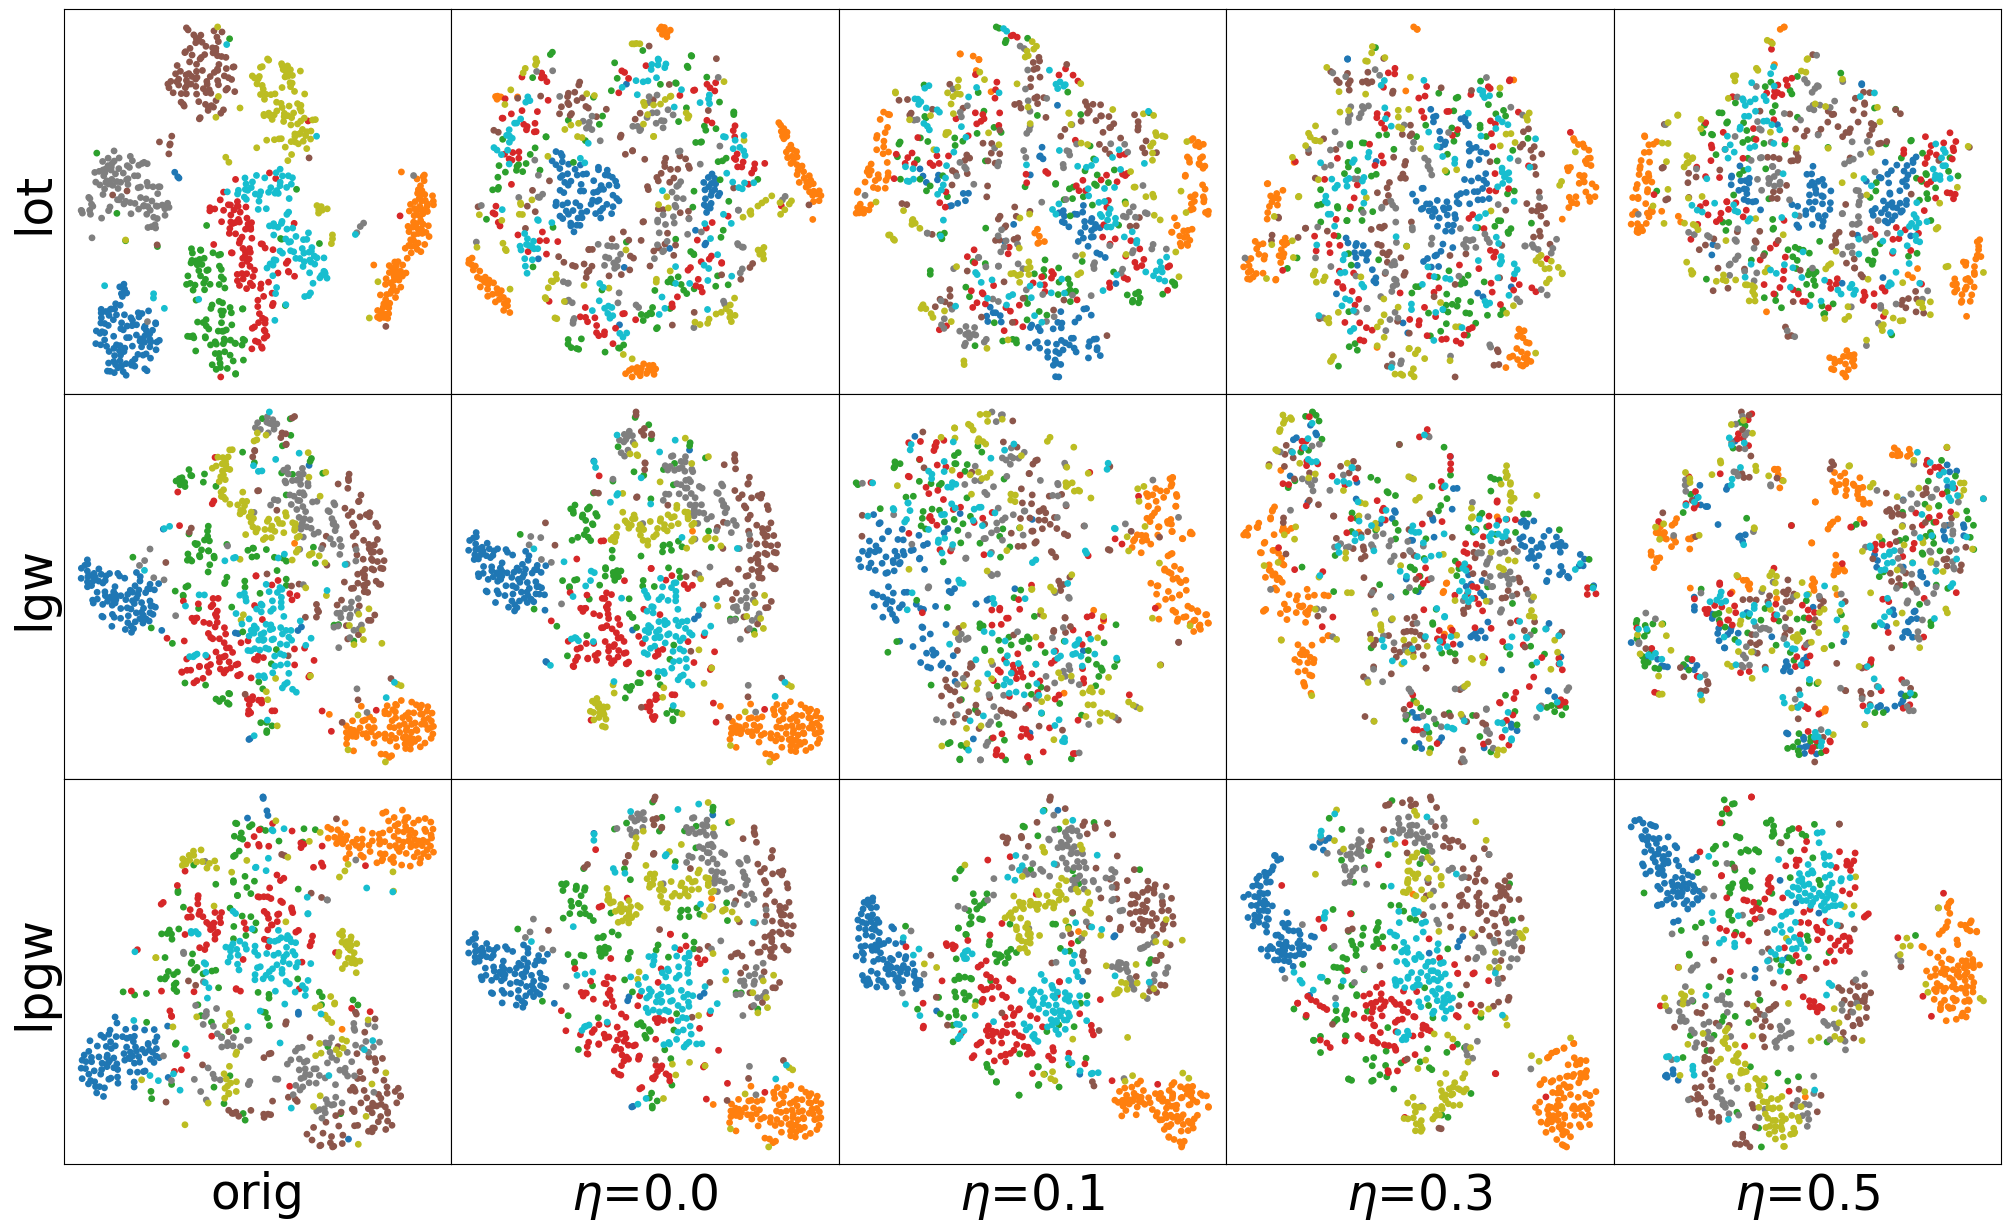

In [189]:
import matplotlib.pyplot as plt 
import pickle 
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression


size1=3
size2=5

# Plotting the embeddings with 3 rows and 5 columns, each containing 3 different labels
fig, axes = plt.subplots(size1, size2, figsize=(5*size2, 5*size1))
#axes = axes.flatten()
#tsne = manifold.TSNE(n_components=2, init="pca", random_state=0)
tsne=TSNE(perplexity=30)
label_list=[0,1,2,3,4,6,7,8]
method_list=['lot','lgw','lpgw']
eta_list=[None,0,0.1,0.3,0.5]
# Plot in each subplot, grouping 3 labels per subplot
for i,method in enumerate(method_list):
    for j,eta in enumerate(eta_list):
        ax=axes[i,j]
        if j==0:
            result=torch.load('results/%s_embedding_test.pt'%(method))
        else:
            result=torch.load('results/%s_embedding_test_%0.3f.pt'%(method,eta))
        result1=np.reshape(result,(result.shape[0],-1))
        embedding_pca= tsne.fit_transform(result1)
        #for label in label_list:
            #indices=np.where(test_Y_sample==label)[0]
        #X=embedding_pca[indices]
        ax.scatter(-embedding_pca[:,0],embedding_pca[:,1],c=test_Y_sample,s=15,cmap='tab10')
        

        ax.set_xticks([])
        ax.set_yticks([])
        #ax.legend(loc='upper left', fontsize='normal', frameon=False)
    
        if i==size1-1:
            if j==0:
                ax.set_xlabel('orig',fontsize=35)
            else:
                ax.set_xlabel(r'$\eta$=%0.1f'%eta,fontsize=35)
        if j==0:
            ax.set_ylabel(method,rotation=90,fontsize=35)

plt.subplots_adjust(wspace=0, hspace=0)

# Save the figure
plt.savefig('results/embeddings_pca.png', bbox_inches='tight', dpi=300)

plt.show()

In [49]:
# visulization: 
ref=torch.load('data/ref.pt')
pos_ref=ref['pos_ref']
M_ref=ref['M_ref']
pmf_ref=ref['pmf_ref']
print(pmf_ref.shape)
eta_list=[0,0.05,0.10,0.3,0.5]

loss='sqrt'
idx1=2
idx2=4

def add_noise(X,pmf,eta=0,mass=1,seed=0,low_bound=-20,upper_bound=25):
    if eta==0:
        return X,pmf
    
    np.random.seed(seed)
    n_pts = X.shape[0]
    n_noise = int(n_pts * eta)
    mass=pmf.sum()
    mass_noise=eta*mass    
    noise_pts = np.random.randint(low_bound, upper_bound, size=(n_noise, 2))
    pmf_noise=np.ones(n_noise)/n_noise*mass_noise 

    X1=np.concatenate((X,noise_pts))
    pmf1=np.concatenate((pmf,pmf_noise))
    return X1,pmf1
    

X1=train_X_sample_pos[size1*idx1]
p1=train_X_sample_pmf[size1*idx1]

X2=train_X_sample_pos[size1*idx2]
p2=train_X_sample_pmf[size1*idx2]

X3,p3=add_noise(X2,p2,eta=0.3,mass=1,seed=1,low_bound=-20,upper_bound=20)


def GW_interporlation(X1,X2,t_list=[0,0.5,1],p1=None,p2=None,loss='sqrt',method='GW',M_ref=None,pmf_ref=None,Lambda=None,loss_param=None):
    assert method in ['GW','LGW','PGW','LPGW']
    assert loss in ['sqrt','graph']
    
    M1=X_to_C(X1,loss=loss,loss_param=loss_param)
    M2=X_to_C(X2,loss=loss,loss_param=loss_param)
    n1,n2,d=M1.shape[0],M2.shape[0],X1.shape[1]
    Ms=[M1,M2]
    ps=[p1,p2]

    clf=PCA(n_components=2)
    
    Mt_list,Xt_list=[],[]
    if M_ref is not None:
        N=M_ref.shape[0]
    else:
        N=int(np.mean([n1,n2]))+1
    if method in ['GW','LGW']:
        ps=[p/p.sum() for p in ps]
    if method =='LGW':
        if M_ref is None:
            N=int(np.mean([n1,n2]))+1
            pmf_ref=np.ones(N)/N
            M_ref=ot.gromov.gromov_barycenters(N, Cs = Ms,
                                            ps = ps, p = pmf_ref, lambdas = ot.unif(2), 
                                            max_iter=100, tol=1e-5,random_state=0,log=False)
        embedding_list=[]
        for (X,pmf,M) in zip([X1,X2],ps,Ms):
            gamma=gromov_wasserstein(M_ref, M, pmf_ref, pmf, G0=None, thres=1, numItermax=500*N, tol=1e-5,log=False, verbose=False,line_search=True)
            embedding,_=LGW_embedding(M_ref,X,pmf_ref,pmf,gamma,loss=loss,loss_param=loss_param)
            embedding_list.append(embedding)

    elif method =='LPGW':
        if Lambda is None:
            Lambda=max(M1.max(),M1.max())/2
        
        if M_ref is None:
            
            pmf_ref=np.ones(N)/N
            M_ref=pgw_barycenters(N, Cs = [M1,M2],
                                            ps = [p1,p2], p = pmf_ref, lambdas = ot.unif(2), Lambda_list=[Lambda,Lambda],
                                            max_iter=100, tol=1e-5,log=False)
        embedding_list=[]
        for (X,pmf,M) in zip([X1,X2],ps,Ms):
            gamma=partial_gromov_ver1(M_ref, M, pmf_ref, pmf, G0=None,Lambda=Lambda, thres=1, numItermax=500*N, tol=1e-5,log=False, verbose=False,line_search=True)
            embedding,_=LPGW_embedding(M_ref,X, pmf_ref, pmf, gamma,Lambda,loss=loss,loss_param=loss_param) 
            embedding_list.append(embedding[0])
    
        

    elif method=='GW':
        for t in t_list:
            lambdas=[1-t,t]
            #normalize qs
            C=ot.gromov.gromov_barycenters(
                N=N, Cs=Ms, ps=ps, p=pmf_ref, lambdas=lambdas,init_C=M_ref, 
                symmetric=True, armijo=False, max_iter=1000, tol=1e-5)
            Mt_list.append(C)
    elif method =='PGW':
        for t in t_list:
            lambdas=[1-t,t]
            C=pgw_barycenters(
                N=N, Cs=Ms, ps=ps, p=pmf_ref, lambdas=lambdas,Lambda_list=[Lambda,Lambda],loss_fun='square_loss',
                init_C=M_ref, max_iter=1000, tol=1e-5)
            
            Mt_list.append(C)
        #return Mt_list,
        
        
        
        
    if method in ['LGW','LPGW']:
        E1,E2=embedding_list[0],embedding_list[1]
        for t in t_list:
            Mt=M_ref+(1-t)*E1+t*E2
            Mt_list.append(Mt)
    


    # convert Mt to Xt
    mds = MDS(n_components=2, metric=True,dissimilarity='precomputed',random_state=0,normalized_stress='auto')

    for Mt in Mt_list:
        Xt=mds.fit_transform(Mt)
        #Xt=clf.fit_transform(Xt.copy())
        Xt_list.append(Xt)
    return Xt_list,Mt_list



        

t_list=np.linspace(0,1,7)
method_list=['GW','PGW','LGW','LPGW']
for method in method_list:
    print('method is',method)
    st=time.time()
    Lambda=50
    Xt_list,_=GW_interporlation(X1,X3,t_list=t_list,p1=p1,p2=p3,loss='sqrt',method=method,M_ref=M_ref,pmf_ref=pmf_ref,Lambda=Lambda,loss_param=None)
    et=time.time()
    print('wall_time is',et-st)
    print(len(Xt_list))
    torch.save(Xt_list,'results_interpolation/%s_1.pt'%(method))


    

(202,)
method is GW
wall_time is 25.433111667633057
7
method is PGW
wall_time is 248.7646074295044
7
method is LGW
wall_time is 2.8540098667144775
7
method is LPGW
wall_time is 1.7960002422332764
7


method is GW
method is PGW
method is LGW
method is LPGW


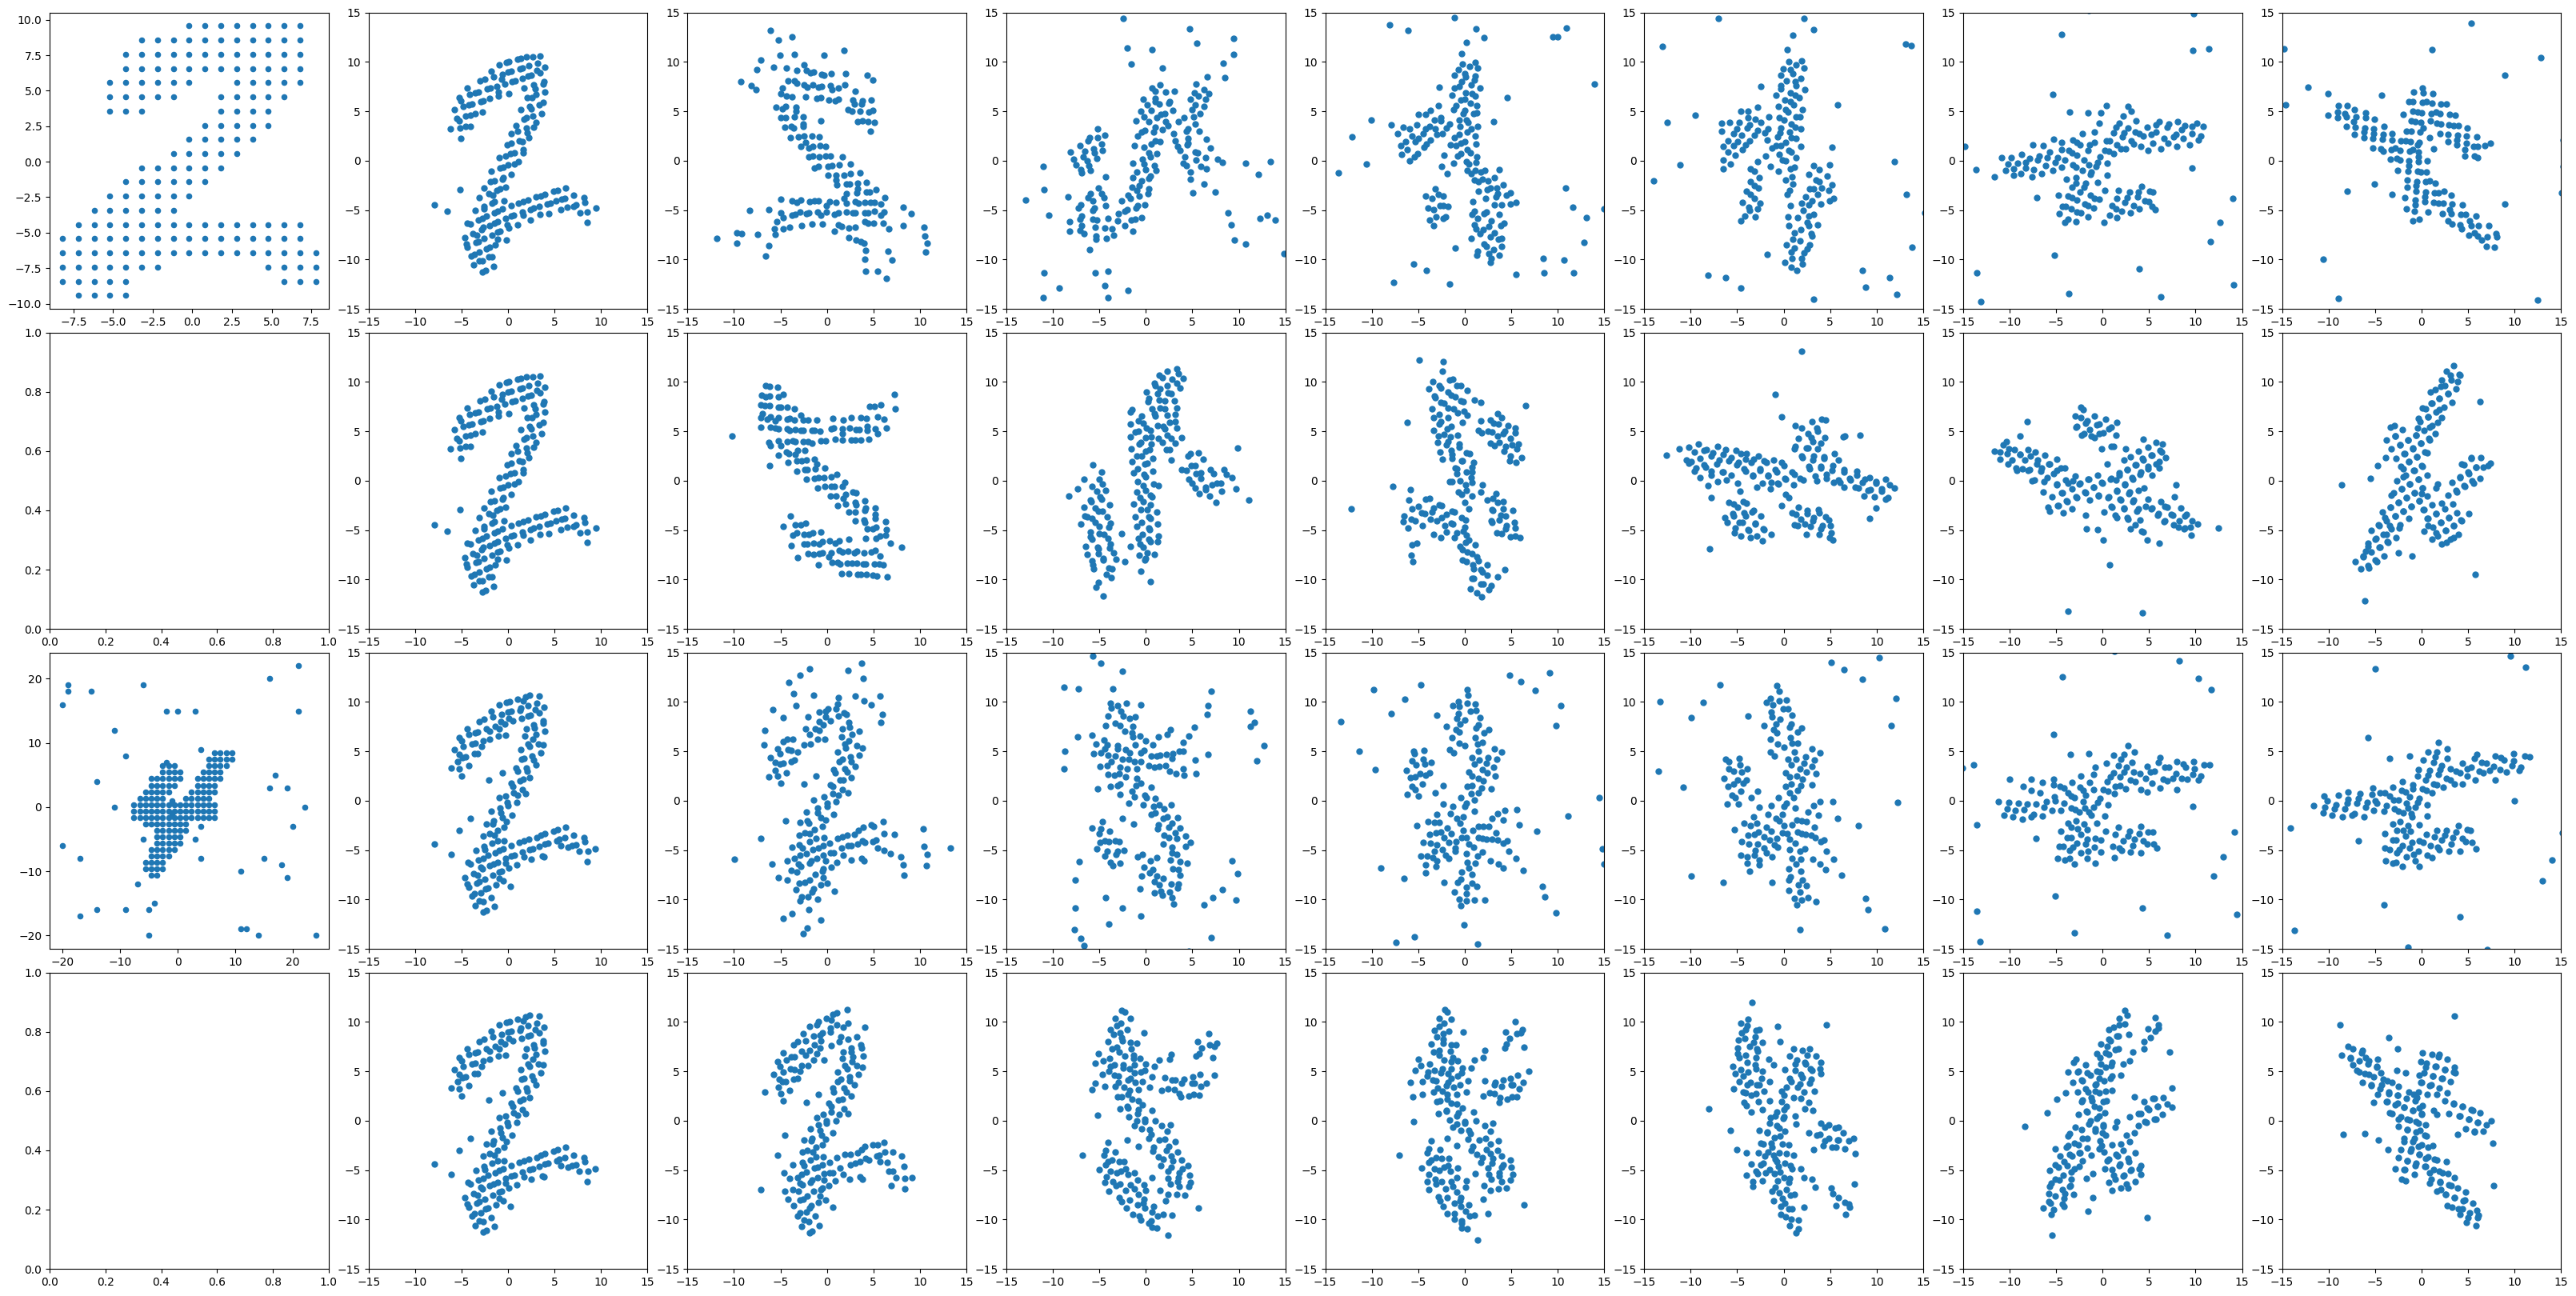

In [47]:
method_list=['GW','PGW','LGW','LPGW']
fig, axs = plt.subplots(4, 8, figsize=(4*8, 4*4))

# R_gw_p=np.array([-0.45*np.pi, -0.6*np.pi, 1/2*np.pi, np.pi, np.pi, np.pi, np.pi, np.pi])
# R_pgw_p=np.array([0.3*np.pi, 3/4*np.pi, 1/2*np.pi, np.pi, np.pi, np.pi, np.pi, np.pi])

# flip_M=np.array([[0,1],[1,0]])

# F_gw=np.array ([[        0,         0,           1,          1,         1,          1,          1,       1],
#                 [        0,         0,           0,          0,         0,          0,          0,       0],
#                 [        0,         1,           1,          0,         0,          0,          0,       0],
#                 [        0,         1,           1,          1,         1,          0,          0,       0],
#                 [        0,         1,           1,          1,         1,          1,          1,       0],
#                 [        0,         1,           1,          1,         0,          0,          1,       0]])

# F_pgw=np.array([[        0,         0,           0,          0,         0,          0,          0,       0],
#                 [        0,         0,           0,          0,         0,          0,          0,       0],
#                 [        0,         0,           0,          0,         0,          0,          0,       1],
#                 [        0,         0,           0,          0,         0,          1,          1,       1],
#                 [        0,         0,           0,          0,         0,          1,          1,       0],
#                 [        0,         0,           0,          1,         0,          1,          1,       1]])

# R_gw= np.array([[0.85*np.pi,  0.8 *np.pi, 1.4*np.pi, 1.4*np.pi, 1.4*np.pi, 1.35*np.pi, 1.35*np.pi, 1.15*np.pi],
#                 [0.85*np.pi,  0.85*np.pi, 1.0*np.pi, 1.4*np.pi, 1.4*np.pi, 1.35*np.pi, 1.25*np.pi, 1.25*np.pi],
#                 [0.85*np.pi,  1.35*np.pi, 1.3*np.pi, 1.7*np.pi, 1.7*np.pi, 1.75*np.pi, 1.75*np.pi, 1.75*np.pi],
#                 [0.85*np.pi,  1.35*np.pi, 1.3*np.pi, 1.3*np.pi, 1.3*np.pi, 1.65*np.pi, 1.75*np.pi, 1.75*np.pi],
#                 [0.85*np.pi,  1.25*np.pi, 1.3*np.pi, 1.3*np.pi, 1.35*np.pi,1.25*np.pi, 1.25*np.pi, 0.75*np.pi],
#                 [0.85*np.pi,  1.25*np.pi, 1.3*np.pi, 1.3*np.pi, 0.8*np.pi, 0.85*np.pi, 1.25*np.pi, 0.75*np.pi]
#               ])
# R_pgw=np.array([[0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.75*np.pi, 0.75*np.pi, 0.75*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.85*np.pi, 0.75*np.pi, 0.25*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 1.25*np.pi, 0.25*np.pi, 1.25*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 0.8*np.pi, 0.8*np.pi, 0.35*np.pi, 1.25*np.pi, 0.75*np.pi],
#                 [0.85*np.pi, 0.85*np.pi, 0.85*np.pi, 1.3*np.pi, 0.8*np.pi, 1.25*np.pi, 1.25*np.pi, 0.25*np.pi]
#               ])


# visulize original data: 
# for i in range(2*2*3):
#     for j in range(9):
#         ax[i,j].set_xticks([])
#         ax[i,j].set_yticks([])
#         if j>=1:
#             ax[i,j].set_xlim([-0.6, 0.5])
#             ax[i,j].set_ylim([-0.5, 0.5]) 

i_row=0
for i,dtype in enumerate(['1']):
    
    for i1,method in enumerate(method_list):
        print('method is',method)

        
        result=torch.load('results_interpolation/%s_%s.pt'%(method,dtype))
        for j,t in enumerate(t_list):
            ax=axs[i_row,j+1]
            X=result[j]
            
            
            ax.scatter(X[:,0], X[:,1],s=25.0)
            ax.set_xlim([-15,15])
            ax.set_ylim([-15,15])
        
        i_row+=1
    for i,X in enumerate([X1,X3]):
        ax=axs[i*2,0]
        ax.scatter(X[:,0],X[:,1],s=20.0)
        
    
        

        




# for j in range(8):
#     ax[11,j+1].set_xlabel(r"$t=%i/7$"%(j), fontsize=35)
# ax[11,0].set_xlabel("data",fontsize=35)

# i0=0
# for i in range(3):
#     for eta in [5,10]:
#         for method in ['GW','PGW']:
#             ax[i0,0].set_ylabel("%s, $%.0f$%%"%(method,eta), fontsize=35,rotation=90)
#             i0+=1


# a=0.011
# for i in range(4):
#     line = plt.Line2D([-0.01, 1], [a+i*(1-a)/3,a+i*(1-a)/3], transform=fig.transFigure, color="black", linewidth=3)
#     fig.add_artist(line)

# b=0.014
# j=1
# line2 = plt.Line2D([b+j*(1-b)/9, b+j*(1-b)/9], [-0.01,1], transform=fig.transFigure, color="black", linewidth=3)
# fig.add_artist(line2)
    
# for i in range(3):
#     line = plt.Line2D([-0.01, 1], [i/3, i/3], transform=fig.transFigure, color="black", linewidth=3)
#     fig.add_artist(line)




plt.tight_layout(pad=0.0)

#plt.savefig('interpolation/interporlation_u.png', dpi=200,bbox_inches='tight')
#plt.savefig('interpolation/interporlation_u.pdf', dpi=200,bbox_inches='tight')
    
plt.show()

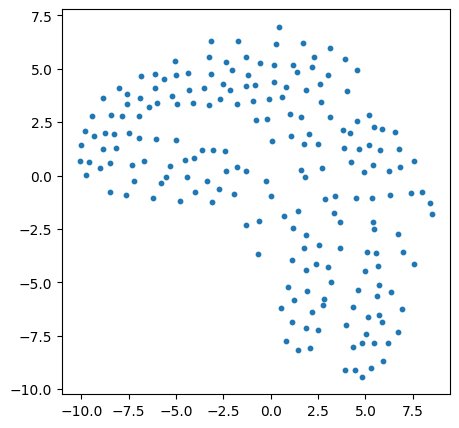

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.scatter(pos_ref[:,0], pos_ref[:,1],s=10)
# Use parentheses here
plt.show()

In [32]:
axs[0,0]

TypeError: 'Axes' object is not subscriptable

In [21]:
i_row

4

In [90]:
result

[]

In [83]:
result

[]

In [81]:
j

0

(235, 2)


In [22]:
print('correct')

embedd_test = np.zeros((test_X.shape[0],N,2))
for i,x in tqdm(enumerate(test_X)):
    b = x[:,2]    
    Y = x[b!=-1,:2]
    Y = Y - Y.mean(0)[np.newaxis,:]
    b = b[b!=-1]
    b = b/b.sum()
    C = ot.dist(X,Y)
    Gamma = ot.emd(a,b,C)
    Yhat = (Gamma/a[:,np.newaxis])@Y
    embedd_test[i,...]=Yhat-X   

### Learn a simple linear classifier on the embedded points
cls = LogisticRegression(max_iter=5000)
cls.fit(embedd.reshape(embedd.shape[0],-1),train_y)
cls.score(embedd_test.reshape(embedd_test.shape[0],-1),test_y)


correct


/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
17149it [12:58, 22.02it/s]


KeyboardInterrupt: 

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


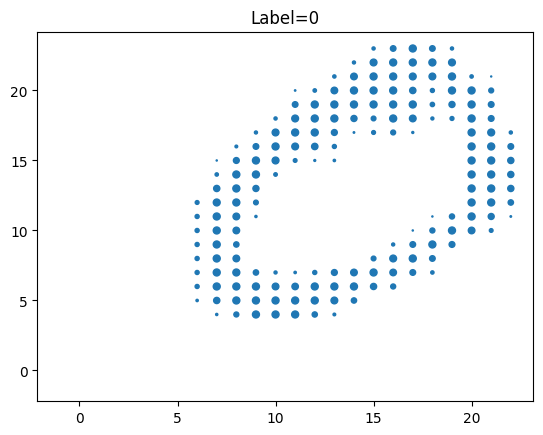

In [9]:

### Load Data
df = pd.read_csv("data/train.csv")
train_X = df[df.columns[1:]].to_numpy()
train_y = df[df.columns[0]].to_numpy()
train_X = train_X.reshape(train_X.shape[0], -1, 3)


ind = 1
plt.scatter(train_X[ind,:,0],train_X[ind,:,1],s=train_X[ind,:,2]*.1)
plt.title('Label=%d'%train_y[ind])

df = pd.read_csv("data/test.csv")
test_X = df[df.columns[1:]].to_numpy()
test_y = df[df.columns[0]].to_numpy()
test_X = test_X.reshape(test_X.shape[0], -1, 3)

del df

### Define Reference

N = 100 # Number of Reference particles
np.random.seed(5)
X = (np.random.rand(N,2)-.5)*20. # Reference

# Xgrid, Ygrid = np.meshgrid(np.linspace(-10,10,10),np.linspace(-10,10,10))
# X = np.stack([Xgrid.reshape(-1),Ygrid.reshape(-1)],1)
a = np.ones(N)/N # Reference mass

### Calculate Embedding
embedd = np.zeros((train_X.shape[0],N,2))
for i,x in tqdm(enumerate(train_X)):
    b = x[:,2]    
    Y = x[b!=-1,:2]
    Y = Y - Y.mean(0)[np.newaxis,:]
    b = b[b!=-1]
    b = b/b.sum()
    C = ot.dist(X,Y)
    Gamma = ot.emd(a,b,C)
    Yhat = (Gamma/a[:,np.newaxis])@Y
    embedd[i,...]=Yhat-X   
embedd_test = np.zeros((test_X.shape[0],N,2))
for i,x in tqdm(enumerate(test_X)):
    b = x[:,2]    
    Y = x[b!=-1,:2]
    Y = Y - Y.mean(0)[np.newaxis,:]
    b = b[b!=-1]
    b = b/b.sum()
    C = ot.dist(X,Y)
    Gamma = ot.emd(a,b,C)
    Yhat = (Gamma/a[:,np.newaxis])@Y
    embedd_test[i,...]=Yhat-X   

### Learn a simple linear classifier on the embedded points
cls = LogisticRegression(max_iter=5000)
cls.fit(embedd.reshape(embedd.shape[0],-1),train_y)
cls.score(embedd_test.reshape(embedd_test.shape[0],-1),test_y)

In [ ]:
clss = 8
inds = np.argwhere(label==clss).squeeze()
N = 100
X = np.random.rand(N,2)-.5
a = np.ones(N)/N
embedd = np.zeros((len(inds),N,2))
for i,ind in enumerate(inds):
    b = Data[ind,:,2]    
    Y = Data[ind,b!=-1,:2]
    Y = Y - Y.mean(0)[np.newaxis,:]
    b = b[b!=-1]
    b = b/b.sum()
    C = ot.dist(X,Y)
    Gamma = ot.emd(a,b,C)
    Yhat = (Gamma/a[:,np.newaxis])@Y
    embedd[i,...]=Yhat-X    
pca = PCA(n_components=4)
pca.fit(embedd.reshape(len(inds),-1))

fig = plt.figure(figsize=(15,3))
for i,y in enumerate(np.linspace(-50,50,4)):    
    for t in np.linspace(-2,2,5):
        Xhat = X+pca.mean_.reshape(100,2)+t*np.sqrt(pca.explained_variance_[i])*pca.components_[i,...].reshape(100,2)
        plt.scatter(Xhat[:,0]+(1-t)*(-25)+t*25,Xhat[:,1]+y,s=a*200,c='C%d'%i,alpha=.5)
plt.axis('off')     
plt.title('OT')